In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
API_KEY = None    # API key for TMDB API. 

# Install Java 8 and Apache spark runtime. 

In [4]:
# Set up Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirrors.hoobly.com/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.7.tgz
!tar xf spark-2.4.6-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install py4j

!export JAVA_HOME=$(/usr/lib/jvm/java-8-openjdk-amd64 -v 1.8)
! echo $JAVA_HOME
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
import findspark
findspark.init("spark-2.4.6-bin-hadoop2.7")# SPARK_HOME

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

/bin/bash: /usr/lib/jvm/java-8-openjdk-amd64: Is a directory
/usr/lib/jvm/java-8-openjdk-amd64


# Load data

Load data into spark

In [5]:
movies_df = spark.read.load("movies.csv", format='csv', header = True)
ratings_df = spark.read.load("ratings.csv", format='csv', header = True)
links_df = spark.read.load("links.csv", format='csv', header = True)
tags_df = spark.read.load("tags.csv", format='csv', header = True)

For ratings DataFrame, drop timestamp, cast userId/movieId to integer and cast rating to float. 

In [6]:
movie_ratings=ratings_df.drop('timestamp')
# Data type convert
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

# Exploratory data analysis
Generate some useful statictics and charts for data visualization and exploratory analysis

In [ ]:
print("Total number of distinct users: {}".format(movie_ratings.select("userId").distinct().count()))
print("Total number of distinct movies: {}".format(movie_ratings.select("movieId").distinct().count()))
print("Total number of ratings: {}".format(movie_ratings.count()))

Total number of distinct users: 610
Total number of distinct movies: 9724
Total number of ratings: 100836


In [ ]:
tmp1 = ratings_df.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings_df.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

Total number of ratings: 100836
For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [ ]:
tmp1 = sum(ratings_df.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings_df.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user


Every movies are categoried into several genres. List all genres using rdd and flatmap.

In [ ]:
from pyspark.sql import Row
genres = movies_df.select("genres").rdd.flatMap(lambda x: x["genres"].split("|")).map(lambda x: Row(genres=x)).toDF()
genres_list = [row["genres"] for row in genres.distinct().collect()]
print("List of all genres: {}".format(genres_list))

List of all genres: ['Crime', 'Romance', 'Thriller', 'Adventure', 'Drama', 'War', 'Documentary', 'Fantasy', 'Mystery', 'Musical', 'Animation', 'Film-Noir', '(no genres listed)', 'IMAX', 'Horror', 'Western', 'Comedy', 'Children', 'Action', 'Sci-Fi']


Count number of ratings for each genre. Genre could be a good feature for embedding. However, we will not use it for our model this time. 

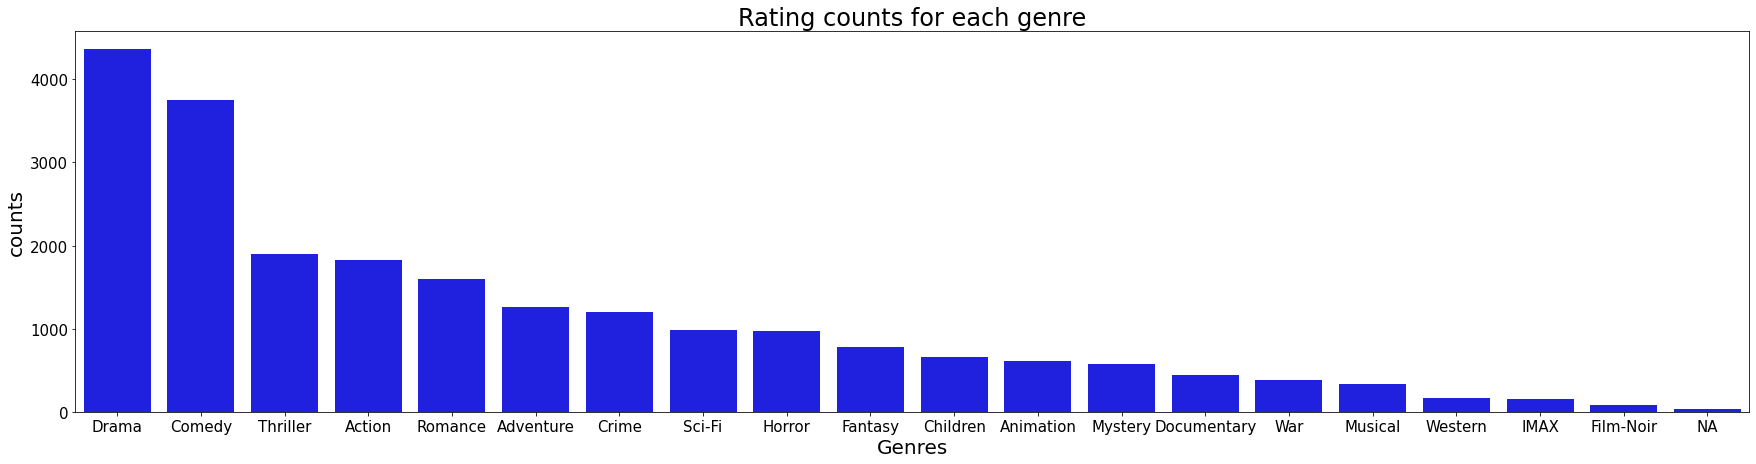

In [ ]:
genres_count = genres.groupBy("genres").count().orderBy("count", ascending = False).toPandas()
genres_count.replace("(no genres listed)", "NA", inplace = True)

fig = plt.figure(figsize = (30, 7))
ax = fig.add_subplot(111)
sns.barplot(x = "genres", y = "count", data = genres_count, color = 'b', ax = ax)
ax.set_xlabel("Genres", fontsize=20)
ax.set_ylabel("counts", fontsize=20)
ax.set_title("Rating counts for each genre", fontsize=24)
ax.tick_params(labelsize = 15)

In [ ]:
genres_count.replace("(no genres listed)", "NA")

genres  count
0         Drama   4361
1        Comedy   3756
2      Thriller   1894
3        Action   1828
4       Romance   1596
5     Adventure   1263
6         Crime   1199
7        Sci-Fi    980
8        Horror    978
9       Fantasy    779
10     Children    664
11    Animation    611
12      Mystery    573
13  Documentary    440
14          War    382
15      Musical    334
16      Western    167
17         IMAX    158
18    Film-Noir     87
19           NA     34

Plot distribution of rating counts for each users. Most users rated 30-50 movies in the dataset. 

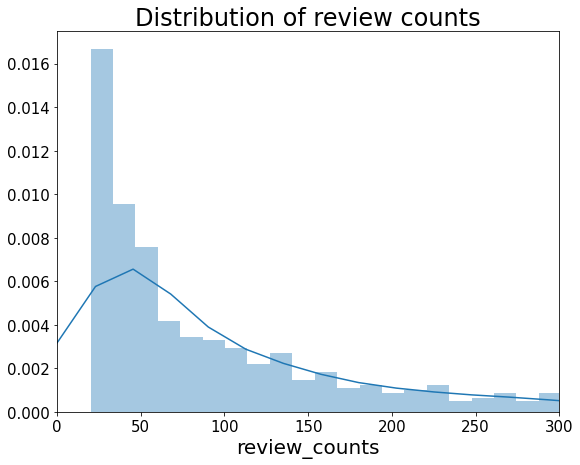

In [ ]:
user_count = ratings_df.groupBy("userId").count().collect()
counts = [row["count"] for row in user_count]

fig = plt.figure(figsize = (9, 7))
ax = fig.add_subplot(111)
sns.distplot(counts, ax = ax, bins = 200)
ax.set_xlabel("review_counts", fontsize=20)
ax.set_title("Distribution of review counts", fontsize=24)
ax.set_xlim((0, 300))
ax.tick_params(labelsize = 15)

Statictics about review counts for each ratings. Most users gave a rating of 3.5-5. 

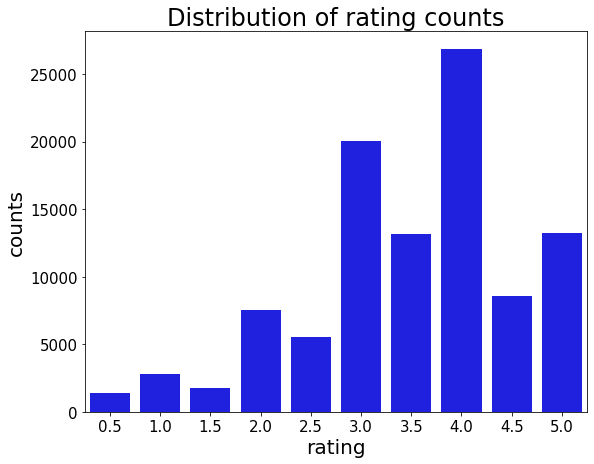

In [ ]:
rating_counts = ratings_df.groupBy("rating").count().toPandas()

fig = plt.figure(figsize = (9, 7))
ax = fig.add_subplot(111)
sns.barplot(x = "rating", y = "count", data = rating_counts, color = 'b', ax = ax)
ax.set_xlabel("rating", fontsize=20)
ax.set_ylabel("counts", fontsize=20)
ax.set_title("Distribution of rating counts", fontsize=24)
ax.tick_params(labelsize = 15)

# Spark ML


## ALS model training

Use collaborative filtering and ALS to model user/item interaction matrix.The basic idea behind collaborative filtering is to embeded each user/movie by a k-dimension vector, the product of the user embedding and movie embedding gives the predicted user rating. \\
This section first import pyspark ALS model and RMSE evaluator for model evaluation.

In [22]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

Splitting the data to 80% train, 20% text. Define RMSE as evaluation metrics. 

In [23]:
(training,test)=movie_ratings.randomSplit([0.8,0.2])
evaluator = RegressionEvaluator(metricName='rmse', labelCol = "rating")

Grid search hyperparameter tunning. Search for rank of the embedding (rank) and regularization parameters (refParam).\\

In [ ]:
result = []
ranks = [5, 10, 15, 20, 30]
regParams = [0.05, 0.1, 0.15, 0.2, 0.3, 0.5]

for rank in ranks:
  tmp = []    # Used to store rmse results for current rank. 
  for regParam in regParams:
    estimator = ALS(rank=rank, regParam=regParam, maxIter = 20, userCol = 'userId', itemCol = "movieId", ratingCol = 'rating', coldStartStrategy = 'drop')
    model = estimator.fit(training)
    test_transformed = model.transform(test)
    rmse = evaluator.evaluate(test_transformed)
    print("Test set RMSE (rank={:2d}, regParam={:.3f}): {:.3f}".format(rank, regParam, rmse))
    tmp.append(rmse)
  result.append(tmp)

Test set RMSE (rank= 5, regParam=0.050): 0.919
Test set RMSE (rank= 5, regParam=0.100): 0.881
Test set RMSE (rank= 5, regParam=0.150): 0.872
Test set RMSE (rank= 5, regParam=0.200): 0.878
Test set RMSE (rank= 5, regParam=0.300): 0.913
Test set RMSE (rank= 5, regParam=0.500): 1.001
Test set RMSE (rank=10, regParam=0.050): 0.937
Test set RMSE (rank=10, regParam=0.100): 0.882
Test set RMSE (rank=10, regParam=0.150): 0.871
Test set RMSE (rank=10, regParam=0.200): 0.878
Test set RMSE (rank=10, regParam=0.300): 0.913
Test set RMSE (rank=10, regParam=0.500): 1.001
Test set RMSE (rank=15, regParam=0.050): 0.947
Test set RMSE (rank=15, regParam=0.100): 0.883
Test set RMSE (rank=15, regParam=0.150): 0.872
Test set RMSE (rank=15, regParam=0.200): 0.878
Test set RMSE (rank=15, regParam=0.300): 0.913
Test set RMSE (rank=15, regParam=0.500): 1.001
Test set RMSE (rank=20, regParam=0.050): 0.950
Test set RMSE (rank=20, regParam=0.100): 0.884
Test set RMSE (rank=20, regParam=0.150): 0.872
Test set RMSE

Show grid search results using heatmap. \\
Find rank = 15, regParam = 0.2 is the best parameter, giving a test RMSE of 0.8782. 

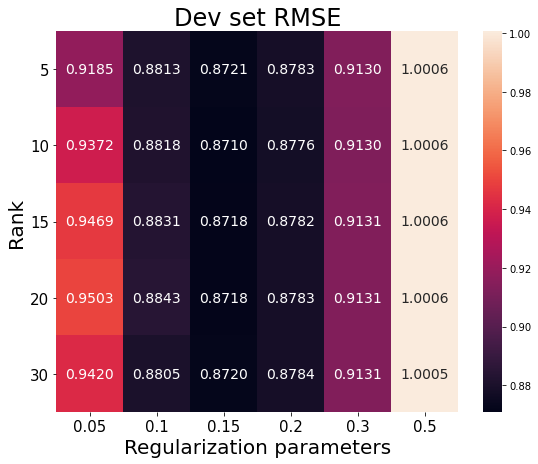

In [ ]:
result_df = pd.DataFrame(result, index = ranks, columns = regParams)

fig = plt.figure(figsize = (9, 7))
ax = fig.add_subplot(111)
sns.heatmap(result_df, annot = True, fmt = ".4f", ax = ax, 
            annot_kws = {"size": 14})
ax.set_xlabel("Regularization parameters", fontsize=20)
ax.set_ylabel("Rank", fontsize=20)
ax.tick_params(labelrotation = 0)
ax.set_title("Dev set RMSE", fontsize=24)
ax.tick_params(labelsize = 15)

Train the best model using the full dataset. Achieved dataset RMSE = 0.723.

In [24]:
#Train best model using full dataset hyperparameter tunning
best_model = ALS(rank=15, regParam=0.2, maxIter = 20, userCol = 'userId', itemCol = "movieId", ratingCol = 'rating', coldStartStrategy = 'drop').fit(movie_ratings)
movie_ratings_transformed = best_model.transform(movie_ratings)
movie_ratings_transformed.cache()
rmse = evaluator.evaluate(movie_ratings_transformed)
print("Full dataset RMSE for best model: {:.3f}".format(rmse))

Full dataset RMSE for best model: 0.723


## Recommend for users

Use pyspark built in API to generate movie recommendation for userID 575 and 232. 

In [25]:
from pyspark.sql import DataFrame
import pandas as pd
user_recommend = spark.createDataFrame(pd.DataFrame({"userID": [575, 232]}))
user_recommend = best_model.recommendForUserSubset(user_recommend, 5)
display(user_recommend.collect())

[Row(userId=232, recommendations=[Row(movieId=59018, rating=4.774628162384033), Row(movieId=60943, rating=4.774628162384033), Row(movieId=3379, rating=4.769795894622803), Row(movieId=67618, rating=4.722644329071045), Row(movieId=33649, rating=4.66806173324585)]),
 Row(userId=575, recommendations=[Row(movieId=141718, rating=5.224217414855957), Row(movieId=3379, rating=4.984988689422607), Row(movieId=59018, rating=4.927881717681885), Row(movieId=60943, rating=4.927881717681885), Row(movieId=102217, rating=4.880917072296143)])]

# ElasticSearch

Use Elasticsearch to find movie similarities and generate movie recommendations for users. 

## Setup ElasticSearch

In [26]:
# Setup elastic search.
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.7.0-linux-x86_64.tar.gz -q
!tar -xzf elasticsearch-7.7.0-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.7.0
# start server
import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.7.0/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )
!pip install elasticsearch
from elasticsearch import Elasticsearch

     |████████████████████████████████| 194kB 3.3MB/s 


In [106]:
# wait a bit then test
!curl -X GET "localhost:9200/"
es = Elasticsearch()
es.info()

{
  "name" : "22af85f83f04",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "fKVBNIQRTyieiC4J-cFyVg",
  "version" : {
    "number" : "7.7.0",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "81a1e9eda8e6183f5237786246f6dced26a10eaf",
    "build_date" : "2020-05-12T02:01:37.602180Z",
    "build_snapshot" : false,
    "lucene_version" : "8.5.1",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


{'cluster_name': 'elasticsearch',
 'cluster_uuid': 'fKVBNIQRTyieiC4J-cFyVg',
 'name': '22af85f83f04',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2020-05-12T02:01:37.602180Z',
  'build_flavor': 'default',
  'build_hash': '81a1e9eda8e6183f5237786246f6dced26a10eaf',
  'build_snapshot': False,
  'build_type': 'tar',
  'lucene_version': '8.5.1',
  'minimum_index_compatibility_version': '6.0.0-beta1',
  'minimum_wire_compatibility_version': '6.8.0',
  'number': '7.7.0'}}

## Transfer data from spark to Elasticsearch

Create mapping for Elasticsearch index, similar to schema for relational databse. 

In [32]:
def make_mapping(item = "moviefactor"):
  if item == "moviefactor":
    field_name = "movieid"
  else:
    field_name = "userid"
  mapping = {"mappings": {
    "properties": {
      field_name: {
        "type": "integer"
      },
      "features": {
        "type": "dense_vector",
        "dims": 15          # Specify size of the embedding. 
      }
    }
  }
  }
  return mapping

Define utility functions to decode pyspark DataFrame into python dictionary. Index (insert) every entries of user embedding vector and movie embedding vector into Elasticsearch. 

In [33]:
# Transfer data from spark dataframe to elasticsearch
def decode_moviefactor(row):
  return {
      "movieid": row["id"],
      "features": row["features"]
  }

def decode_userfactor(row):
  return {
      "userid": row["id"],
      "features": row["features"]
  }

def decode_link(row):
  return {
      "movieId": row["movieId"],
      "imdbId": row["imdbId"]
  }

# Write entry one by one to Elasticsearch
def transfer_to_es(item = "moviefactor"):
  if item == "moviefactor":
    data = best_model.itemFactors
    index_name = "movie_features"
    decode = decode_moviefactor
  elif item == "userfactor":
    data = best_model.userFactors
    index_name = "user_features"
    decode = decode_userfactor
  elif item == "links":
    data = links_df
    index_name = "links"
    decode = decode_link
  
  # Delete and create new index (database). 
  es.indices.delete(index = index_name, ignore = 404)
  es.indices.create(index = index_name, ignore = 400, body = make_mapping(item))
  # Write documents (entries) in to index. 
  for row in data.collect():
    es.index(index = index_name, body = decode(row))

transfer_to_es("moviefactor")
transfer_to_es("userfactor")
transfer_to_es("links")

Print out total number of users and movies in Elasticsearch.

In [34]:
print("There are {} users and {} movies in Elasticsearch.".format(
    es.count(index = "user_features")["count"],
    es.count(index = "movie_features")["count"]
))

There are 610 users and 9724 movies in Elasticsearch.


## Movie recommendation using Elasticsearch

Define utility functions to retrieve movie title and posters using TMDB API. 

In [35]:
import requests
from IPython.display import Image, display

def get_title(id):
  url_format = "https://api.themoviedb.org/3/find/{external_id}?api_key={api_key}&language=en-US&external_source=imdb_id"
  url = url_format.format(external_id=id, api_key=API_KEY)
  response = requests.get(url).json()   # Convert response to JSON format (python dict)
  title = response["movie_results"][0]["title"]
  date = response["movie_results"][0]["release_date"]
  return title, date

def get_poster(id):
  # Get configuration info. 
  CONFIG_PATTERN = 'http://api.themoviedb.org/3/configuration?api_key={api_key}'
  config = requests.get(CONFIG_PATTERN.format(api_key=API_KEY)).json()
  base_url = config['images']['base_url']
  sizes = config['images']['poster_sizes']
  """
      'sizes' should be sorted in ascending order, so
          max_size = sizes[-1]
      should get the largest size as well.        
  """
  def size_str_to_int(x):
      return float("inf") if x == 'original' else int(x[1:])
  max_size = max(sizes, key=size_str_to_int)

  # Get image url.
  url_format = 'http://api.themoviedb.org/3/movie/{imdbid}/images?api_key={api_key}' 
  response = requests.get(url_format.format(api_key=API_KEY, imdbid=id)).json()
  url = "{base_url}{size}{rel_path}".format(base_url = base_url, size = max_size, rel_path = response["posters"][0]["file_path"])

  # Download image.
  r = requests.get(url).content    # Convert response to byte strings
  return r

def display_image(bytes, width = 200):
  display(Image(bytes, width = width))

Define utility functions to generate similar movies or recommendations for users.

In [61]:
def get_factor(id, item = "movie"):
  # Given id of movie or user, return factors of shape (k,)
  if item == "movie":
    query_title = "movieid"
    index_title = "movie_features"
  elif item == "user":
    query_title = "userid"
    index_title = "user_features"

  query = {
      "query":{
          "match": {query_title: id}
      }
  }
  res = es.search(index = index_title, body = query)
  return res["hits"]["hits"][0]["_source"]['features']

def get_similar(features, num = 5, item = "movie"): 
  # Get movie id that is similar to features. 
  # Features could be either user feature (for user recommendation) or movie feature (find similar movies). 
  if item == "movie" or item == "user":
    # Use cosine similarity for movie similarity. 
    formula = "cosineSimilarity(params.query_vector, 'features')"
  elif item == "user":
    # Use dot product for user recommendation. 
    formula = """
            double value = dotProduct(params.query_vector, 'features');
            return sigmoid(1, Math.E, -value); 
          """

  query = {"query": {
    "script_score": {
      "query": {"match_all": {}},
      "script": {
        "source": formula,
        "params": {"query_vector": features}
      }
    }
  }}
  res = es.search(index = "movie_features", body = query)
  movieid = [entry["_source"]["movieid"] for entry in res["hits"]["hits"]]
  return movieid[:num]

def user_rated_highly(userid):
  # Get the top 5 movies that the user rated highly
  top_5 = movie_ratings.where(movie_ratings.userId == userid).orderBy("rating", ascending = False).limit(5).toPandas()
  movieids = top_5["movieId"].tolist()
  return movieids

def movie_id_to_imdb(movieid):
  # Convert movie id to imdbid. 
  query = {
    "query":{
        "match": {"movieId": movieid}
    }
  }
  res = es.search(index = "links", body = query)
  return int(res["hits"]["hits"][0]['_source']['imdbId'])

def get_user_movie_rating(userid, movieids):
  # given userid and movieid, get the user rating for the movie_ratings table. Used to evaluate recommendation accuracy
  if type(movieids) != list:
    movieids = [movieids]
  res = movie_ratings.select("rating").where("userId = {}".format(userid)).where(movie_ratings.movieId.isin(set(movieids))).collect()
  if res:
    return [row.rating for row in res]
  return []

def show_poster(imdbids):
  # Show movie titles and posters with movies in imdbids list.
  for id in imdbids:
    try:
      imdbid = "tt{:07d}".format(int(id))
      print(get_title(imdbid))
      display_image(get_poster(imdbid))      
    except:
      pass

def recommend_for_user(userid, num = 5):
  # Given userid, show all recommended movies and titles if user exist. 
  user = get_factor(userid, item = "user")
  if user == None:
    print("User not found")
    return
  
  user_rated = user_rated_highly(userid)                # Top 5 movies rated highly by user
  similar_movieid = get_similar(user, num = num, item = "user") # Top 5 recommendations for user.
  user_rated_imdbid = [movie_id_to_imdb(id) for id in user_rated]
  similar_imdbid = [movie_id_to_imdb(id) for id in similar_movieid]
  
  print("Movies user {} previously rated highly:".format(userid))
  show_poster(user_rated_imdbid)
  print("******************************************************************************************")
  print("Recommendation for user {}:".format(userid))
  show_poster(similar_imdbid)

def similar_movie(movieid, num = 5):
  # Given movieid, show all recommended movies and titles if user exist. 
  movie = get_factor(movieid, item = "movie")
  if movie == None:
    print("Movie not found")
    return
  similar_movieid = get_similar(movie, num = num+1, item = "movie")[1:]
  imdbids = [movie_id_to_imdb(id) for id in similar_movieid]      # Convert movie_id to imdbid

  print("Movies similar to:")
  show_poster([movie_id_to_imdb(movieid)])
  print("******************************************************************************************")
  print("Similar movies: ")
  show_poster(imdbids)

Movies similar to:
('Star Wars: Episode I - The Phantom Menace', '1999-05-19')


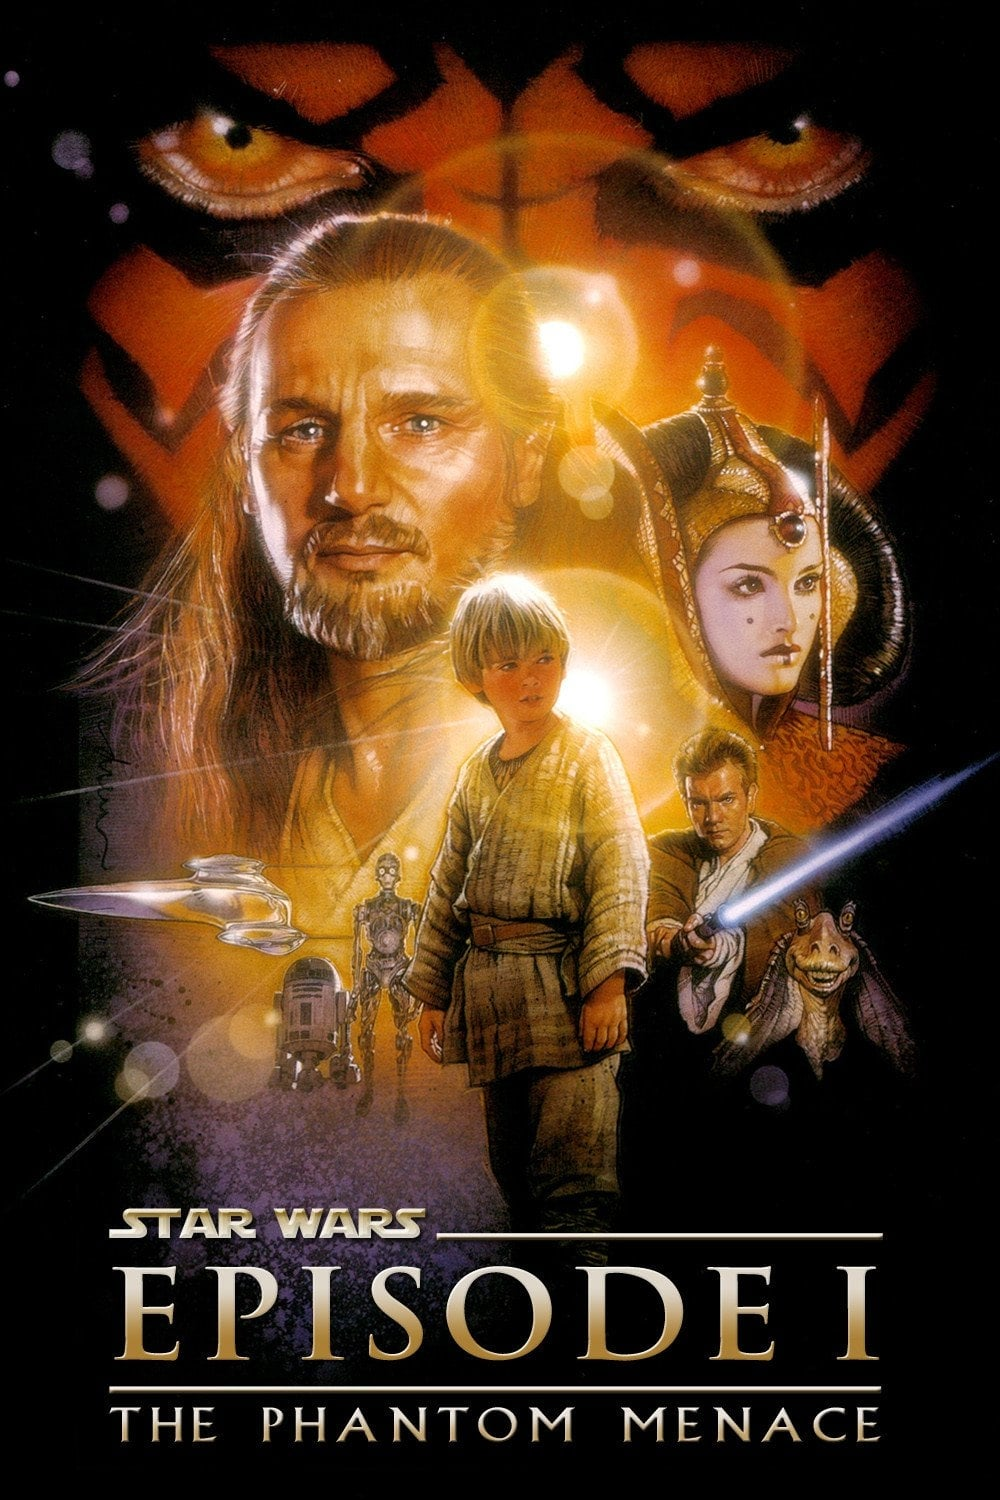

******************************************************************************************
Similar movies: 
('Fantastic Four', '2005-06-29')


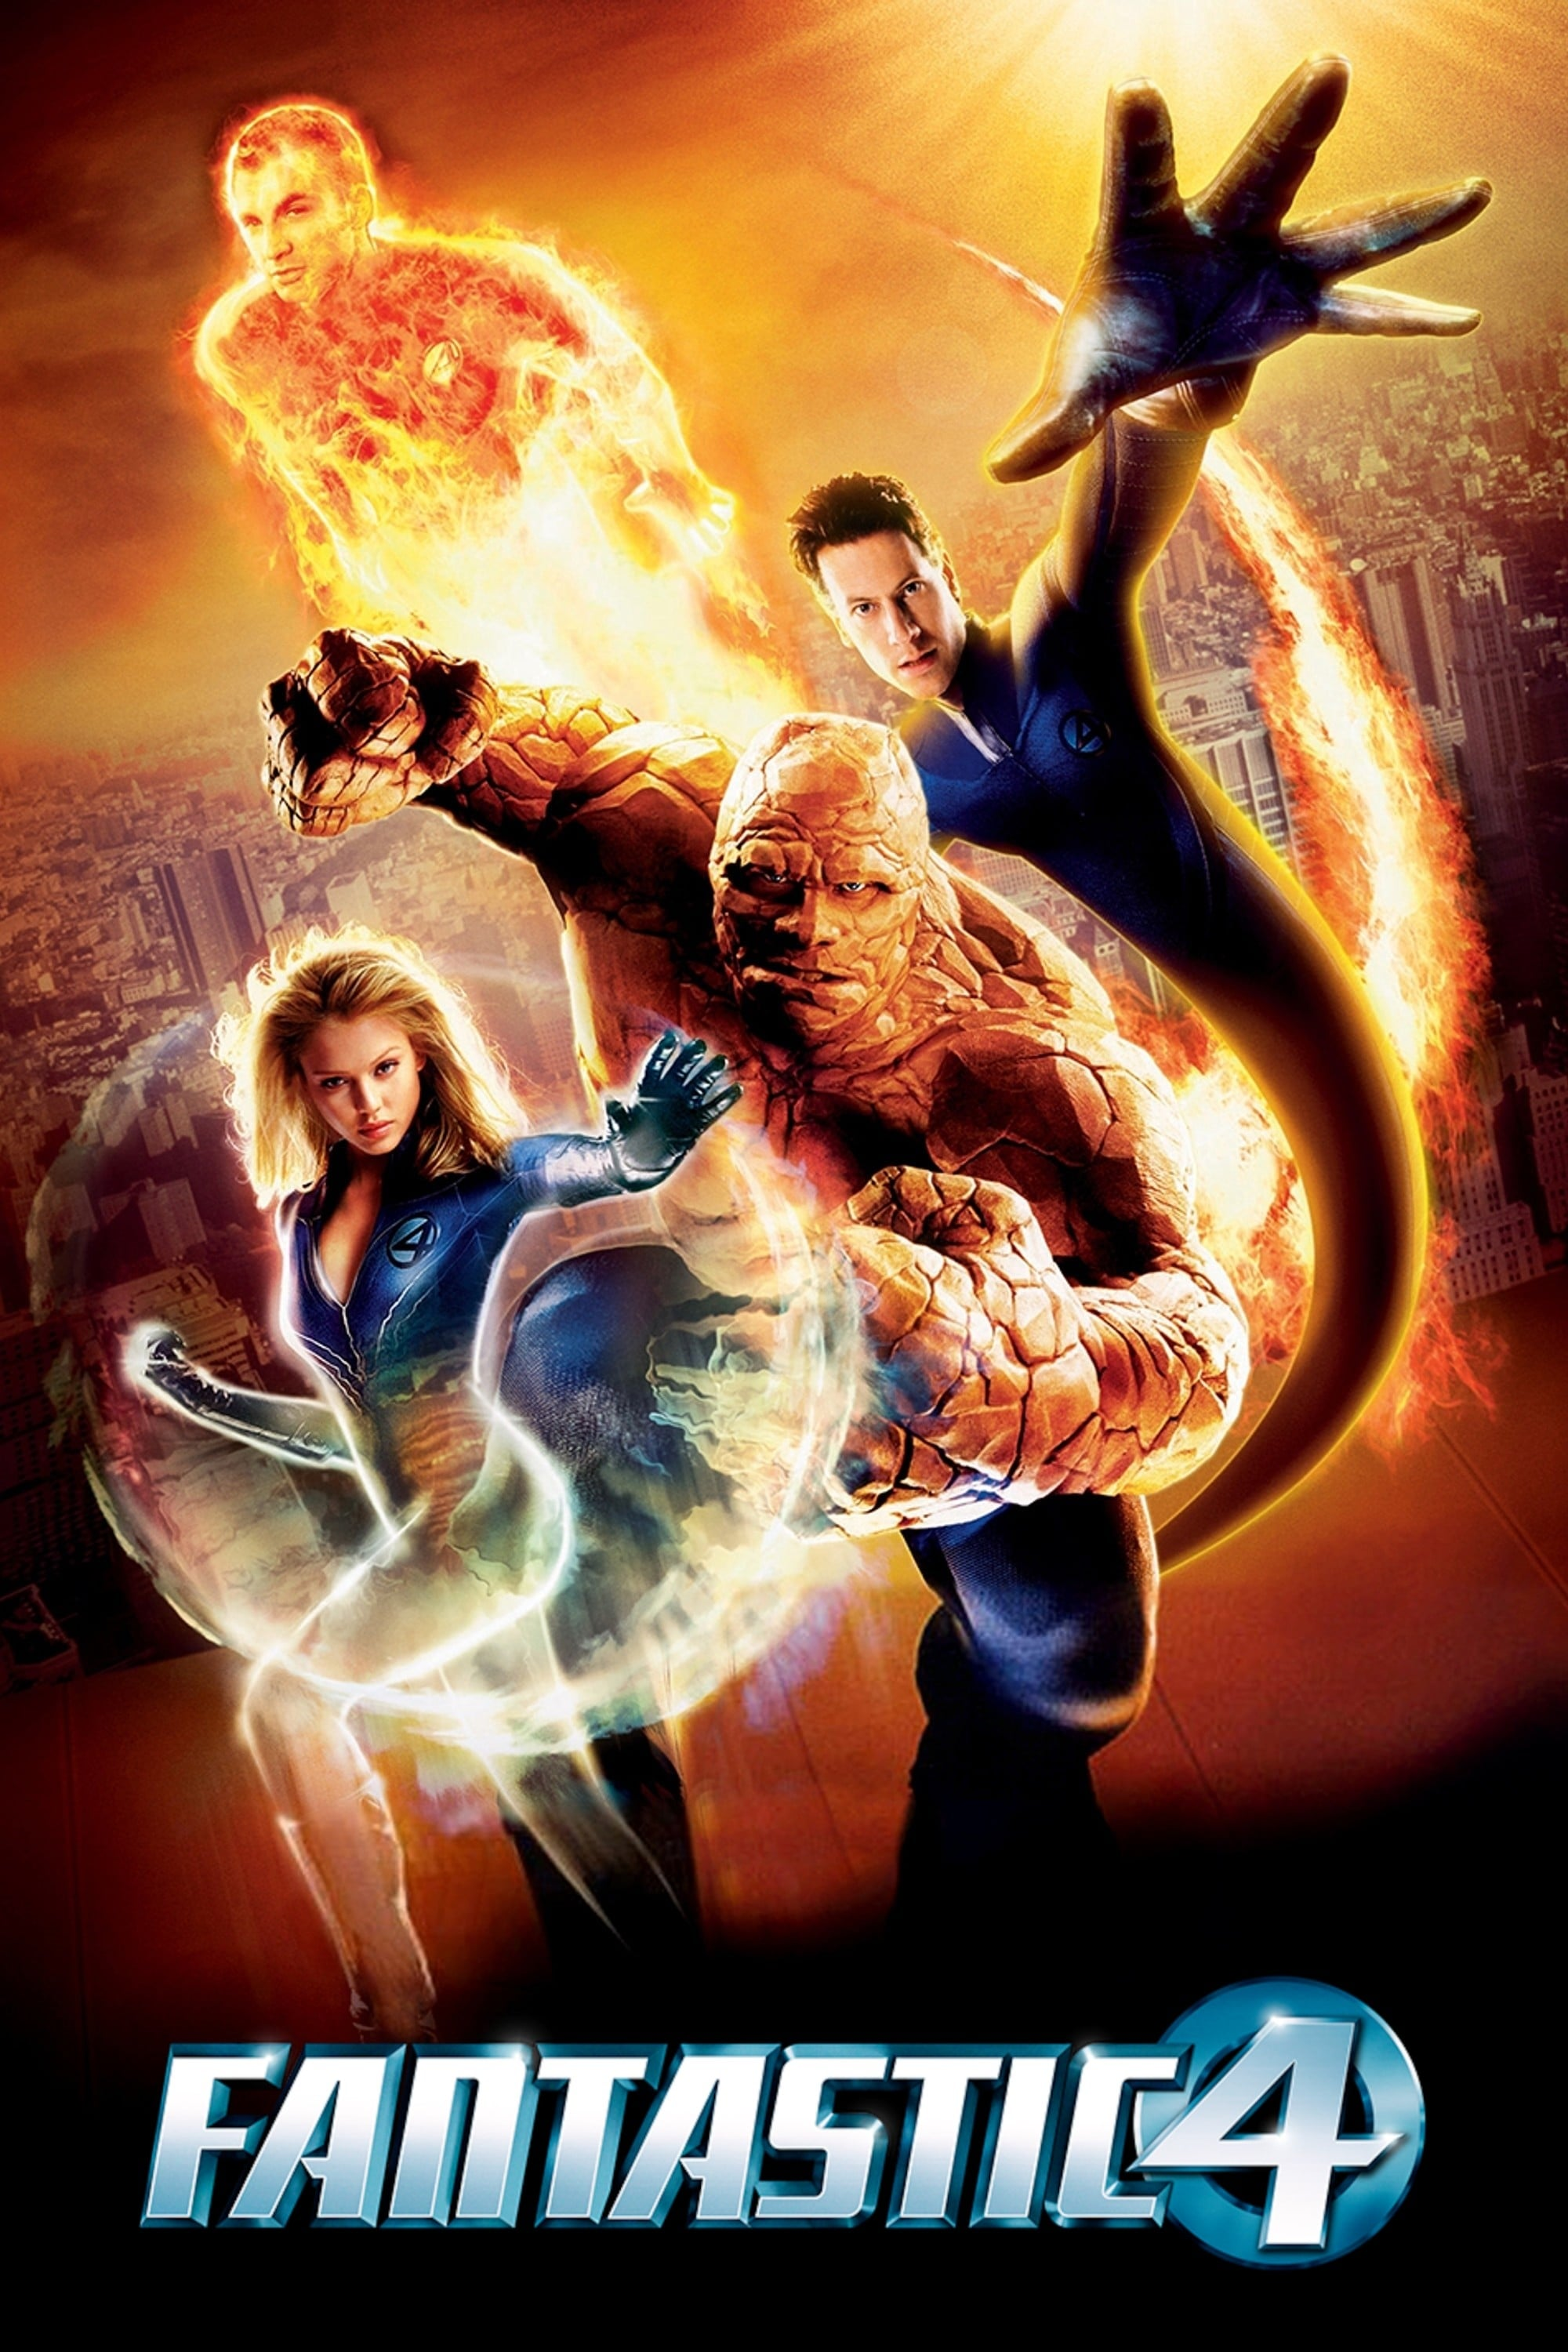

('World War Z', '2013-06-20')


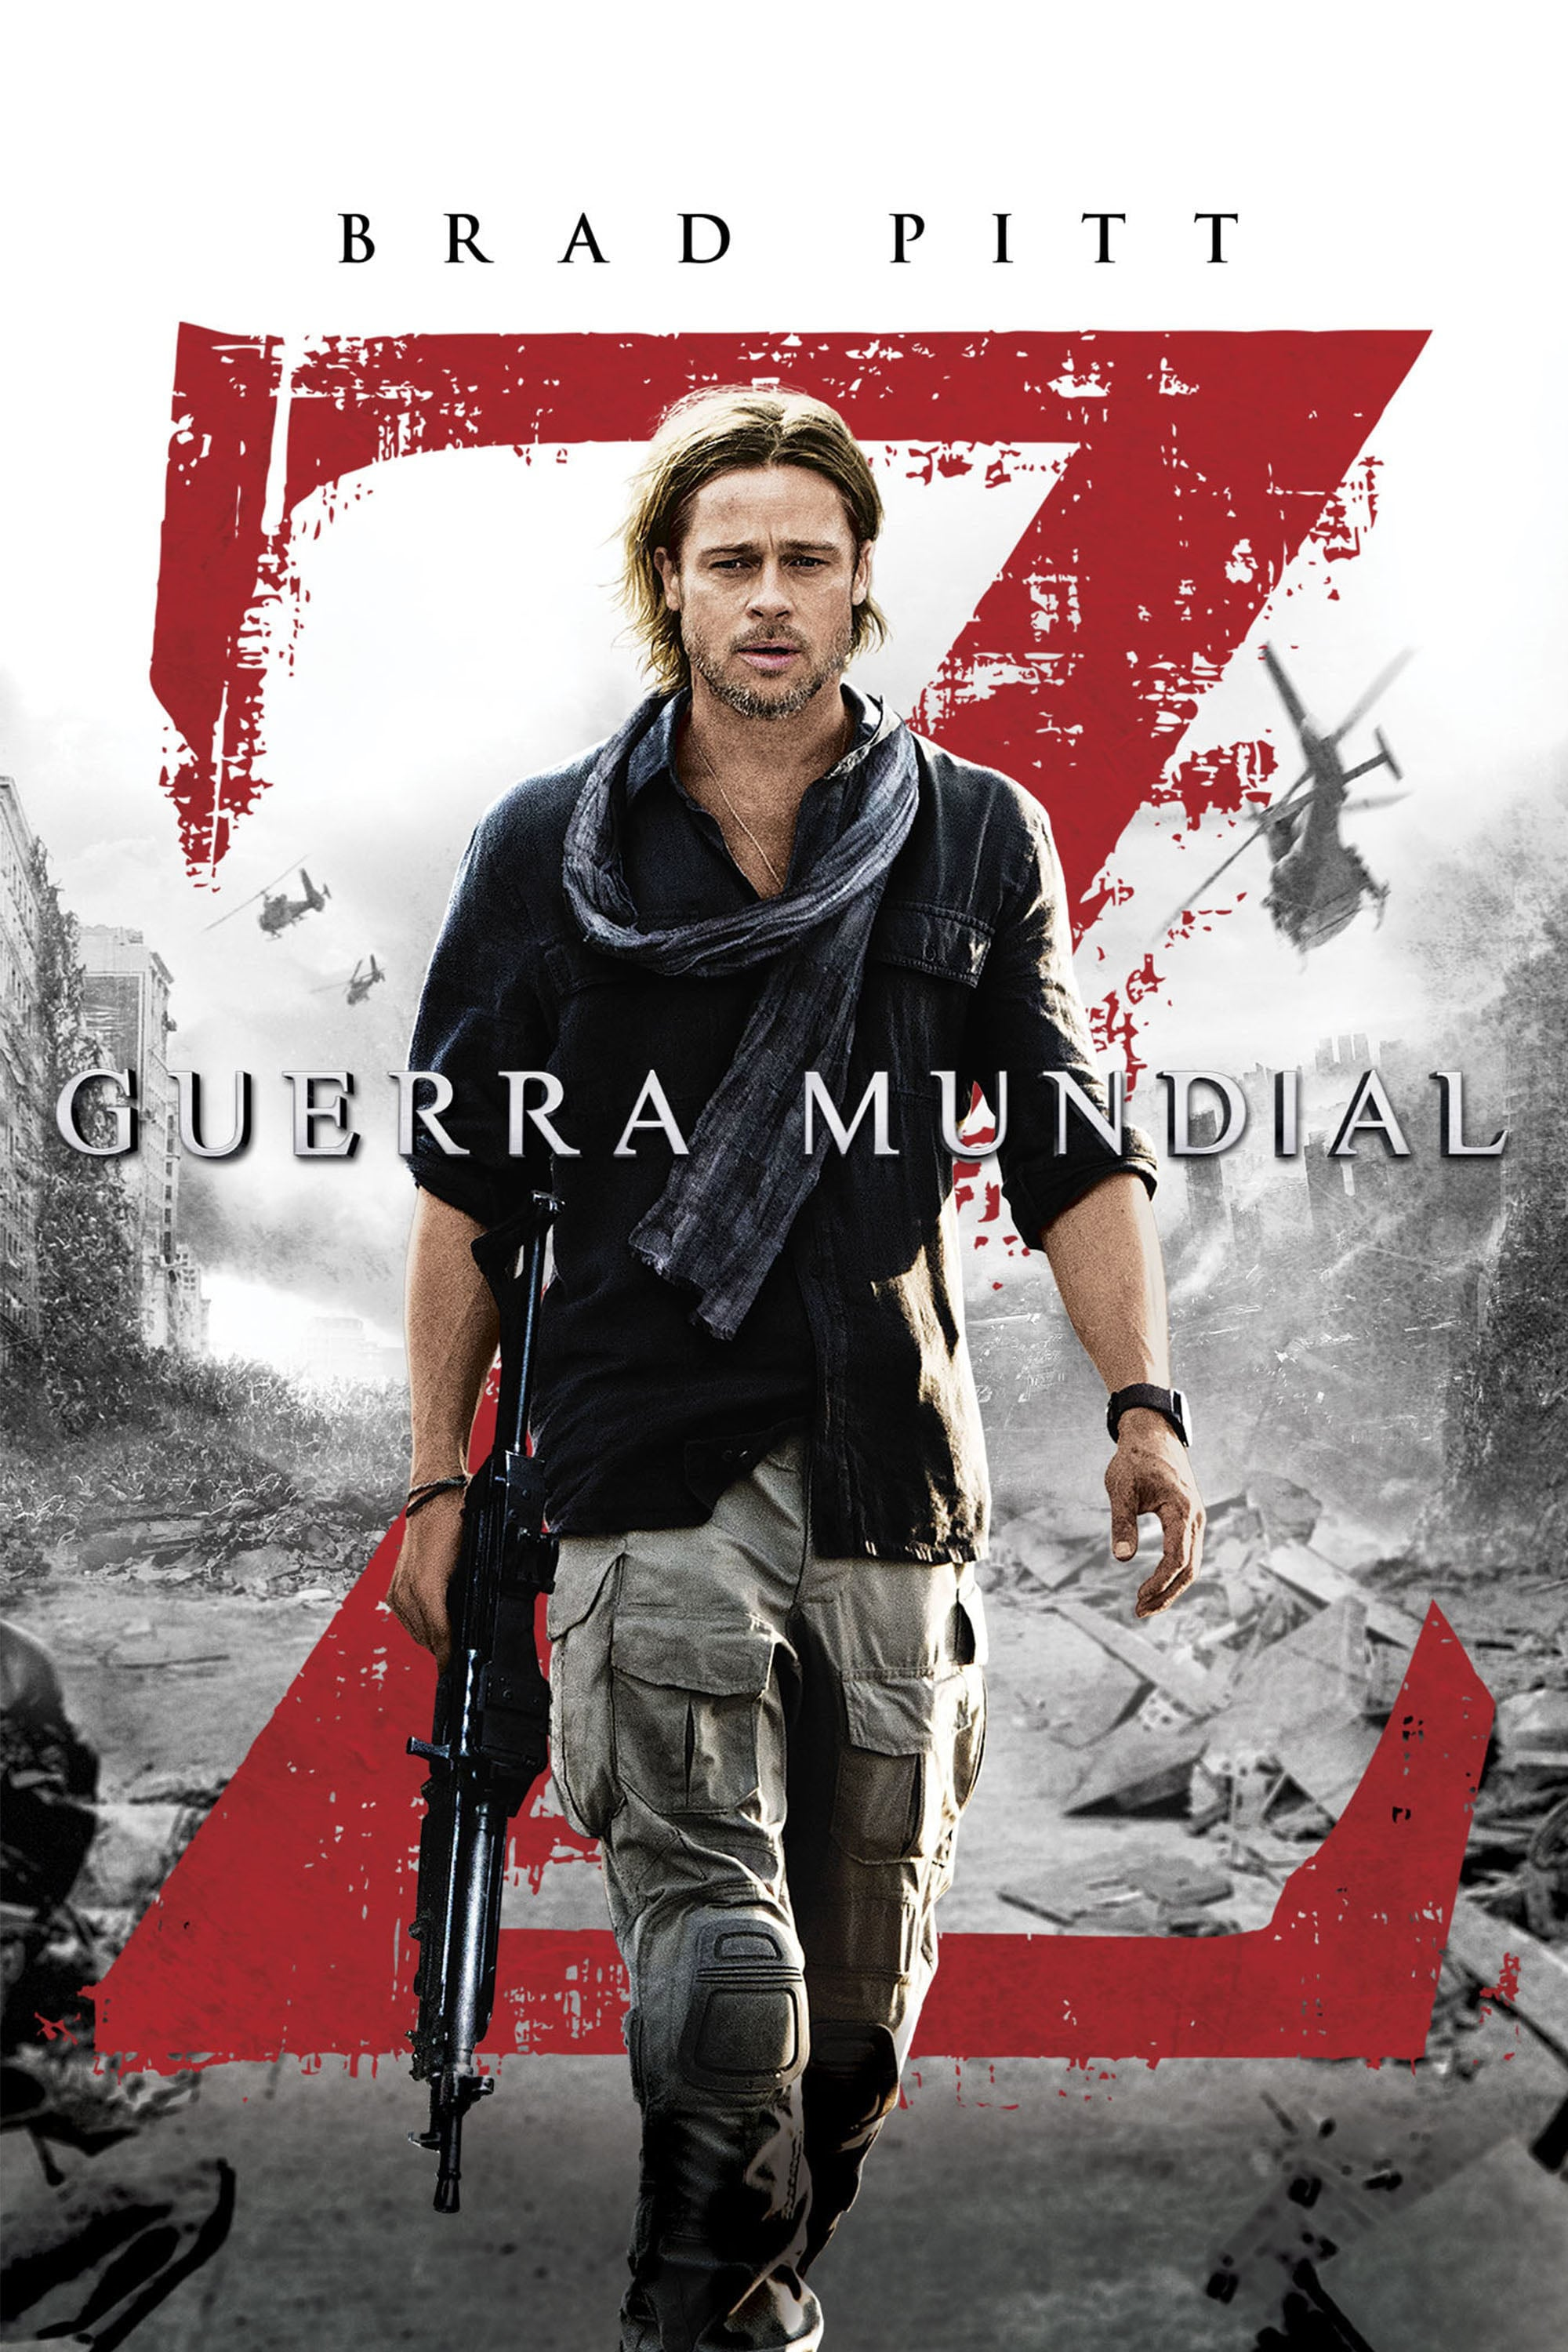

('The Hunger Games: Mockingjay - Part 2', '2015-11-18')


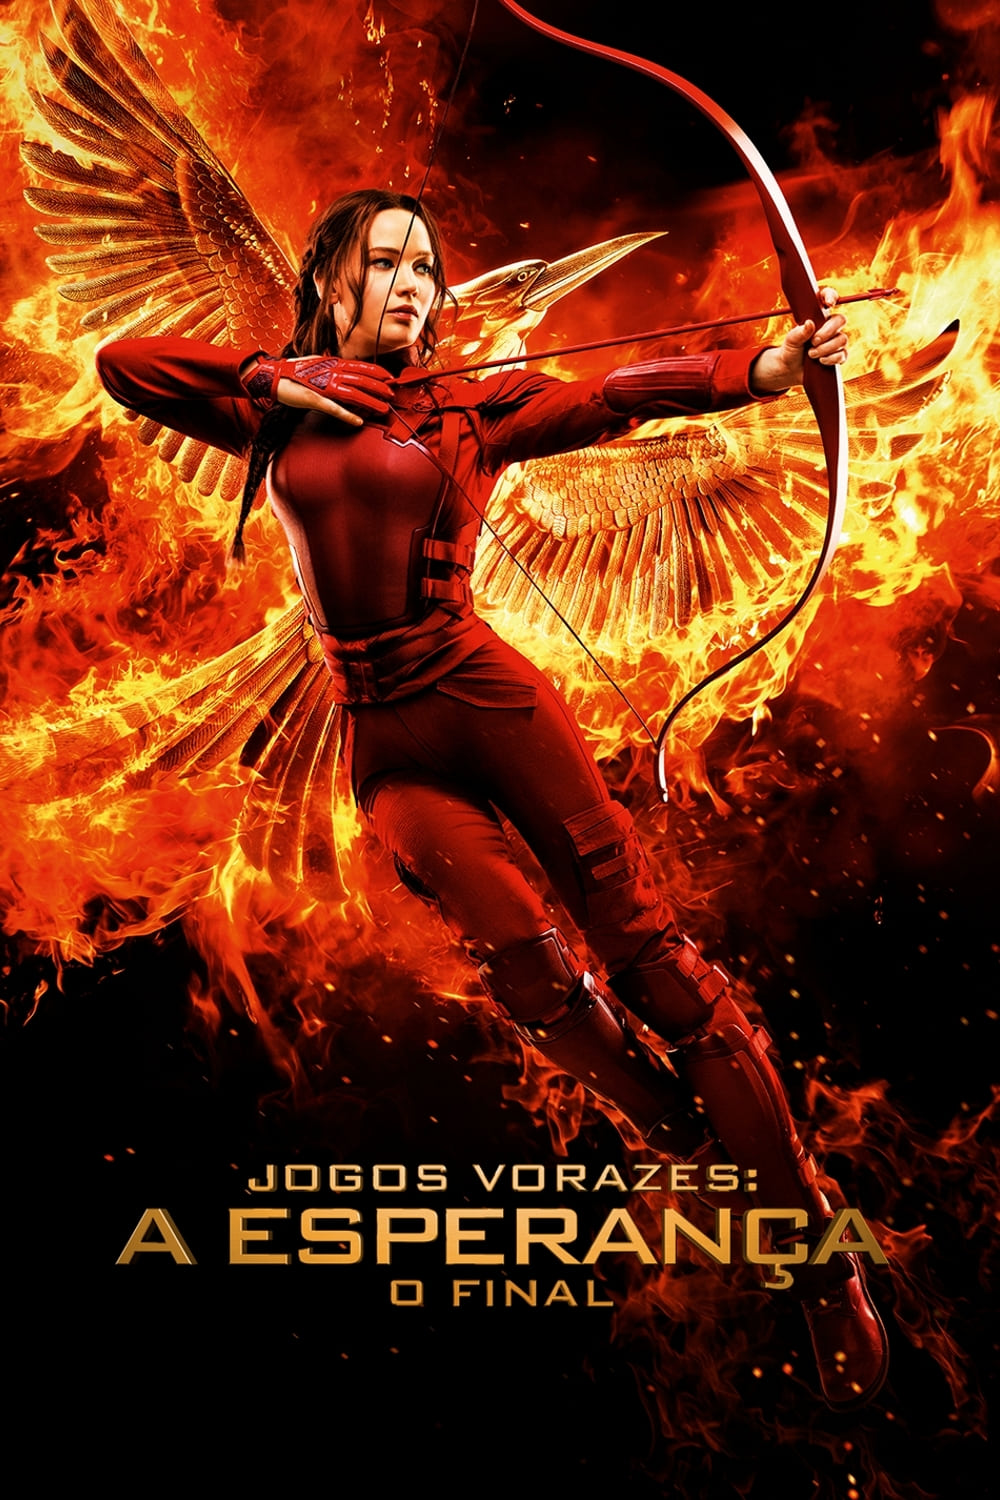

('The Lorax', '2012-03-01')


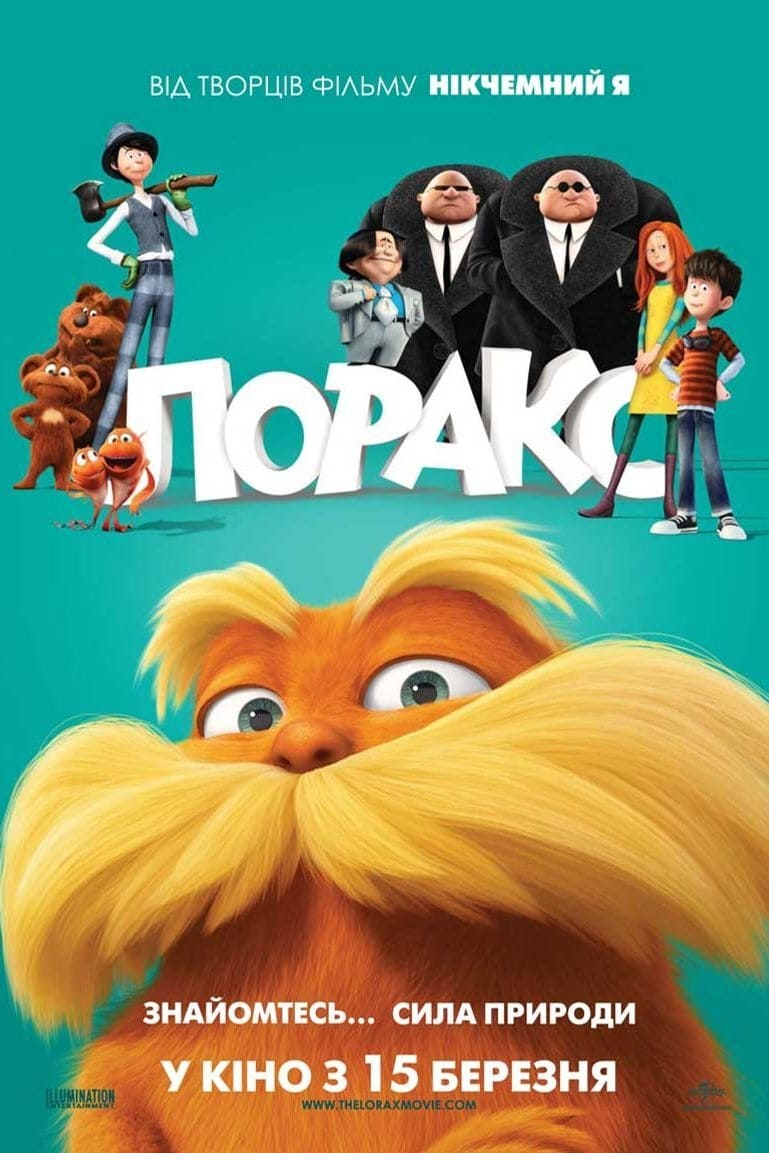

('Star Wars: Episode II - Attack of the Clones', '2002-05-15')


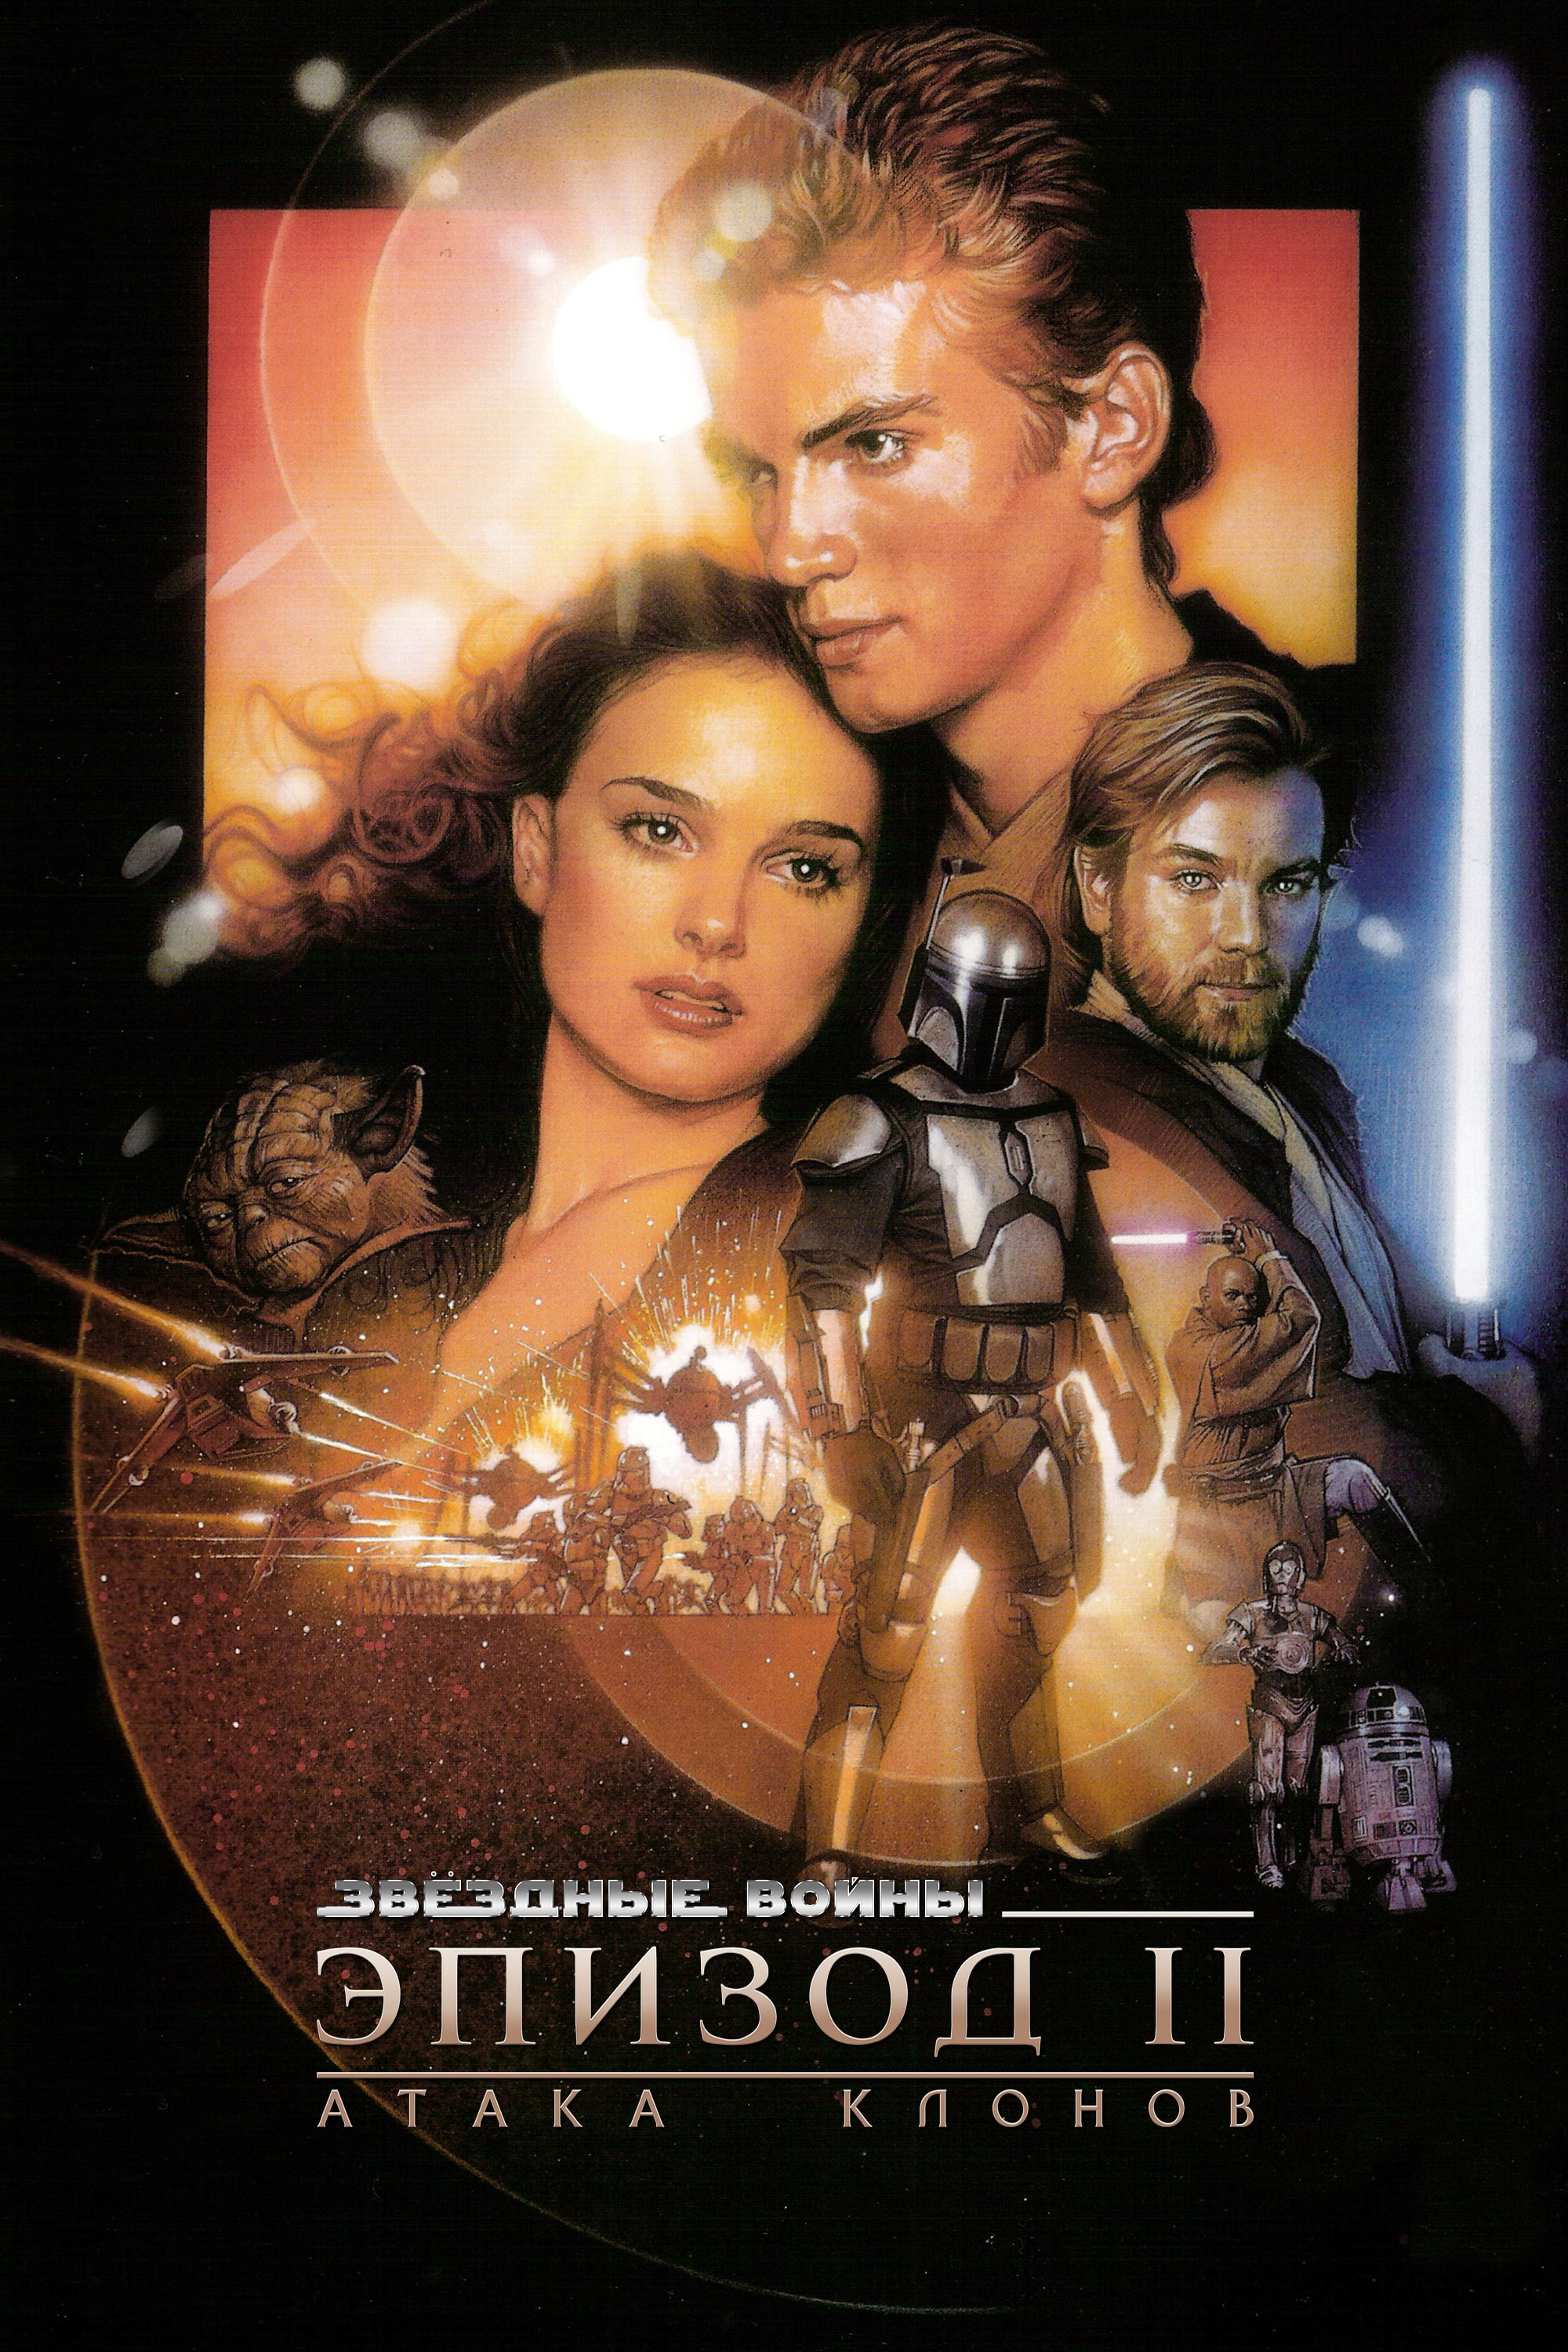

In [45]:
similar_movie(2628)

In [38]:
recommend_for_user(210)

Movies user 210 previously rated highly:
******************************************************************************************
Recommendation for user 210:


## Evaluate top 2/5/10 hit rate

In [69]:
userid_list = [row.userId for row in movie_ratings.select("userId").distinct().collect()]
print(len(userid_list))
print(userid_list)
num = 10

610
[148, 463, 471, 496, 243, 392, 540, 31, 516, 85, 137, 251, 451, 580, 65, 458, 53, 255, 481, 588, 133, 296, 472, 78, 322, 513, 321, 362, 375, 593, 597, 108, 155, 34, 193, 211, 368, 530, 101, 115, 126, 81, 385, 28, 183, 210, 436, 497, 596, 300, 406, 412, 587, 76, 26, 27, 332, 501, 577, 384, 44, 159, 192, 271, 606, 253, 103, 236, 329, 460, 12, 336, 350, 223, 388, 417, 548, 602, 91, 409, 578, 333, 222, 285, 601, 22, 128, 209, 330, 372, 604, 122, 230, 319, 493, 93, 157, 190, 225, 232, 233, 246, 346, 360, 367, 476, 539, 599, 111, 224, 519, 47, 140, 177, 416, 556, 132, 152, 444, 185, 305, 353, 355, 291, 325, 386, 435, 473, 581, 603, 146, 259, 512, 1, 206, 52, 297, 363, 212, 274, 182, 442, 13, 218, 280, 348, 440, 6, 16, 86, 474, 168, 205, 572, 3, 142, 178, 308, 328, 20, 40, 164, 429, 470, 169, 500, 139, 283, 359, 479, 295, 340, 431, 94, 250, 377, 402, 432, 582, 57, 570, 292, 306, 339, 54, 120, 559, 491, 96, 235, 545, 452, 48, 266, 507, 544, 5, 163, 191, 268, 258, 279, 19, 397, 430, 92, 419

Generate top k hit rate as a float number.  
Top k hit rate defined as: Avg(# of movies rated highly by the user / # of movies recommended to the user). Average over all users. When evaluating the top k hit rate, we discarded movies that are not rated by the user. Thus "# of movies recommended to the user" != k.

In [117]:
def get_top_k_hit_rate(k):

  hit_rate_sum = 0
  total_count = 0
  for i, userid in enumerate(userid_list):
    try:
      user_factor = get_factor(userid, item = "user")
      recommend = get_similar(user_factor, num = k, item = "user")
      user_rating = get_user_movie_rating(userid, recommend)
      if user_rating:
        hit_rate_sum += sum(int(rating > 2.5) for rating in user_rating) / len(user_rating)
        total_count += 1
      if (i+1) % 50 == 0:
        print("Finished {}/{}".format(i+1, len(userid_list)))
    except:
      pass
  return hit_rate_sum / total_count

In [118]:
print("Top {} hit rate: {:.1f}%".format(2, get_top_k_hit_rate(2) * 100))
print("Top {} hit rate: {:.1f}%".format(5, get_top_k_hit_rate(5) * 100))
print("Top {} hit rate: {:.1f}%".format(10, get_top_k_hit_rate(10) * 100))

Finished 50/610
Finished 100/610
Finished 150/610
Finished 250/610
Finished 300/610
Finished 350/610
Finished 400/610
Finished 450/610
Finished 500/610
Finished 550/610
Finished 600/610
Top 2 hit rate: 86.4%
Finished 50/610
Finished 100/610
Finished 150/610
Finished 250/610
Finished 300/610
Finished 350/610
Finished 400/610
Finished 450/610
Finished 500/610
Finished 550/610
Finished 600/610
Top 5 hit rate: 88.8%
Finished 50/610
Finished 100/610
Finished 150/610
Finished 250/610
Finished 300/610
Finished 350/610
Finished 400/610
Finished 450/610
Finished 500/610
Finished 550/610
Finished 600/610
Top 10 hit rate: 91.0%
